# Initial Setup

In [28]:
%%capture
%load_ext autoreload
%autoreload 2

from tqdm.notebook import trange, tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import mplfinance as mpl

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from IPython.display import Audio
sound_file = '../sound/done.mp3'
Audio(sound_file, autoplay=True)

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model


# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

## Get NYSE calendar

In [2]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [3]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [4]:
cbd = pd.offsets.CustomBusinessDay(calendar=NYSE)
cbd

<CustomBusinessDay>

# YFinance

## Setup / Gather Data

In [5]:
ticker = 'SPY'
YF_COLUMNS = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

In [6]:
years = [3,5,10]
get_yf_time_series(yf, years, ticker, freq=cbd)

## Load Data from File

### 3Y

In [7]:
spy_df_3Y = load_yf_time_series(yf, 3, ticker, freq=cbd)

### 5Y

In [8]:
spy_df_5Y = load_yf_time_series(yf, 5, ticker, freq=cbd)

### 10Y

In [9]:
spy_df_10Y = load_yf_time_series(yf, 10, ticker, freq=cbd)

## Data Preparation

### EDA

In [10]:
spy_df_5Y

,open,high,low,close,adj_close,volume
date,,,,,,
2016-05-02,206.919998,208.179993,206.410004,207.970001,189.178101,62188000
2016-05-03,206.520004,206.800003,205.279999,206.160004,187.531647,106422100
2016-05-04,204.990005,205.850006,204.419998,205.009995,186.485535,92243800
2016-05-05,205.559998,205.979996,204.470001,204.970001,186.449203,67619200
2016-05-06,204.059998,205.770004,203.880005,205.720001,187.131424,89315000
...,...,...,...,...,...,...
2021-04-29,420.320007,420.720001,416.440002,420.059998,420.059998,78544300
2021-04-30,417.630005,418.540009,416.339996,417.299988,417.299988,85448400
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300


In [11]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

### Set up Frequency

In [12]:
spy_df_3Y = spy_df_3Y.asfreq(cbd)
spy_df_5Y = spy_df_5Y.asfreq(cbd)
spy_df_10Y = spy_df_10Y.asfreq(cbd)

In [13]:
spy_df_5Y.isna().sum()

open         46
high         46
low          46
close        46
adj_close    46
volume       46
dtype: int64

### Remove today's incomplete data (if needed)

In [14]:
# spy_df_3Y.drop(spy_df_3Y.tail(1).index, inplace=True)
# spy_df_5Y.drop(spy_df_5Y.tail(1).index, inplace=True)
# spy_df_10Y.drop(spy_df_10Y.tail(1).index, inplace=True)

### Impute Missing Values

In [15]:
spy_df_3Y = spy_df_3Y.interpolate()
spy_df_5Y = spy_df_5Y.interpolate()
spy_df_10Y = spy_df_10Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [16]:
df_full_3Y_close = spy_df_3Y.close
df_full_3Y_vol = spy_df_3Y.volume
df_full_5Y_close = spy_df_5Y.close
df_full_5Y_vol = spy_df_5Y.volume
df_full_10Y_close = spy_df_10Y.close
df_full_10Y_vol = spy_df_10Y.volume

In [17]:
df_full_5Y_close

date
2016-05-02    207.970001
2016-05-03    206.160004
2016-05-04    205.009995
2016-05-05    204.970001
2016-05-06    205.720001
                 ...    
2021-04-29    420.059998
2021-04-30    417.299988
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
Freq: C, Name: close, Length: 1308, dtype: float64

In [18]:
df_full_10Y_close, df_full_10Y_vol

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2021-04-29    420.059998
 2021-04-30    417.299988
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 Freq: C, Name: close, Length: 2613, dtype: float64,
 date
 2011-05-02    126278700.0
 2011-05-03    138375000.0
 2011-05-04    182678500.0
 2011-05-05    226900000.0
 2011-05-06    222787200.0
                  ...     
 2021-04-29     78544300.0
 2021-04-30     85448400.0
 2021-05-03     68128300.0
 2021-05-04    101591200.0
 2021-05-05     39873700.0
 Freq: C, Name: volume, Length: 2613, dtype: float64)

### Create Time Series for `Open`, `High`, `Low`, `adj_close`

In [19]:
df_full_3Y_open = spy_df_3Y.open
df_full_3Y_high = spy_df_3Y.high
df_full_3Y_low = spy_df_3Y.open
df_full_3Y_a_close = spy_df_3Y.adj_close
df_full_5Y_open = spy_df_5Y.open
df_full_5Y_high = spy_df_5Y.high
df_full_5Y_low = spy_df_5Y.open
df_full_5Y_a_close = spy_df_5Y.adj_close
df_full_10Y_open = spy_df_10Y.open
df_full_10Y_high = spy_df_10Y.high
df_full_10Y_low = spy_df_10Y.open
df_full_10Y_a_close = spy_df_10Y.adj_close

### Create 2D Volume Time Series

In [20]:
df_full_3Y_close.shape

(787,)

In [21]:
vol_3Y_df = pd.DataFrame(df_full_3Y_vol).reset_index()
vol_5Y_df = pd.DataFrame(df_full_5Y_vol).reset_index()
vol_10Y_df = pd.DataFrame(df_full_10Y_vol).reset_index()

### Create Future Dates

In [22]:
# no longer needed due to custom function

today = pd.Timestamp.today()
new_dates = pd.date_range(start=today, periods=5, freq=cbd)

index_3Y_fc = range(df_full_3Y_close.size, df_full_3Y_close.size + 5)
index_5Y_fc = range(df_full_5Y_close.size, df_full_5Y_close.size + 5)
index_10Y_fc = range(df_full_10Y_close.size, df_full_10Y_close.size + 5)

new_dates_3Y_df = pd.DataFrame(new_dates, index=index_3Y_fc, columns=['date'])
new_dates_5Y_df = pd.DataFrame(new_dates, index=index_5Y_fc, columns=['date'])
new_dates_10Y_df = pd.DataFrame(new_dates, index=index_10Y_fc, columns=['date'])

## Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



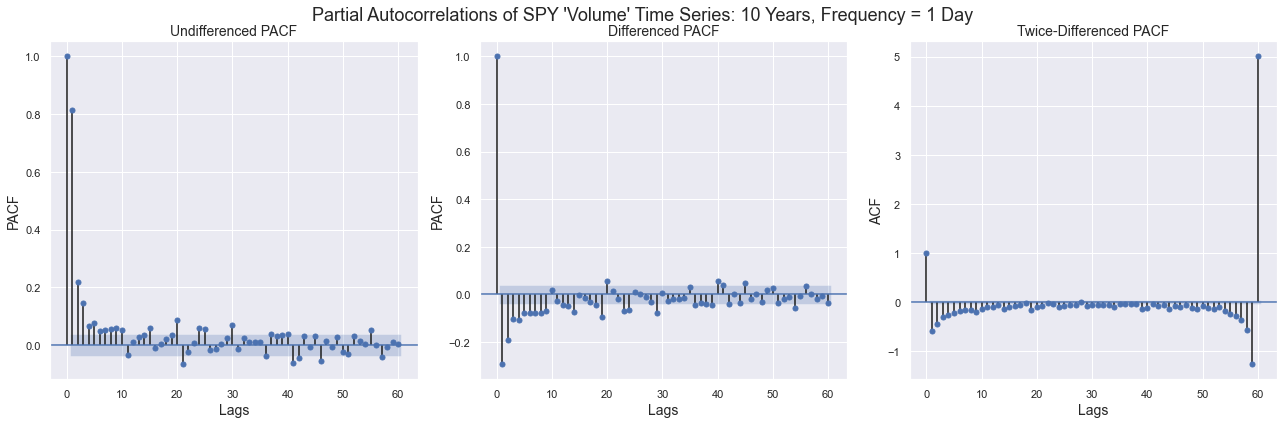

In [255]:
plot_pacf_with_diff(df_full_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', lags=60)

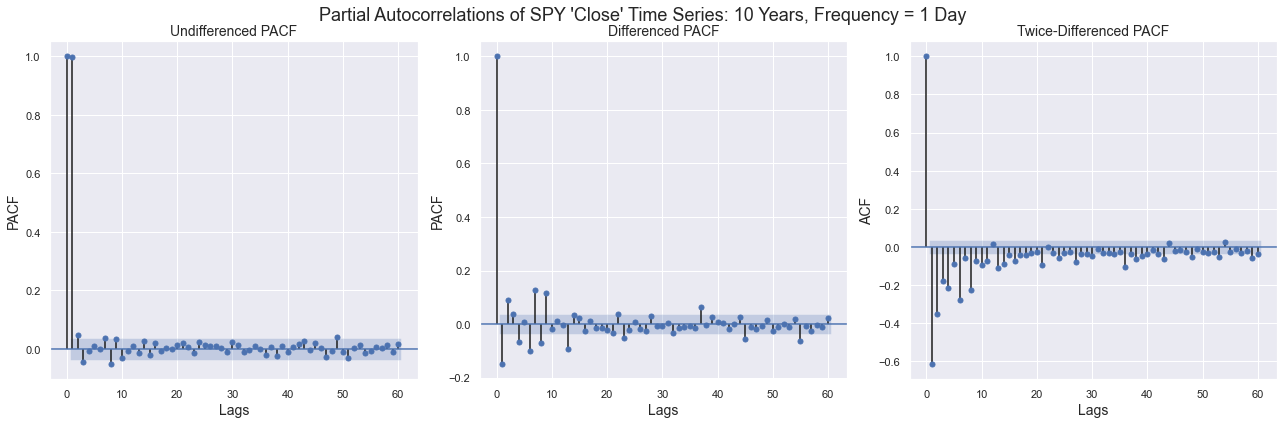

In [257]:
plot_pacf_with_diff(df_full_10Y_close.interpolate(), 'SPY \'Close\'', 10, 'years', '1 Day', lags=60)

## Plot ACF

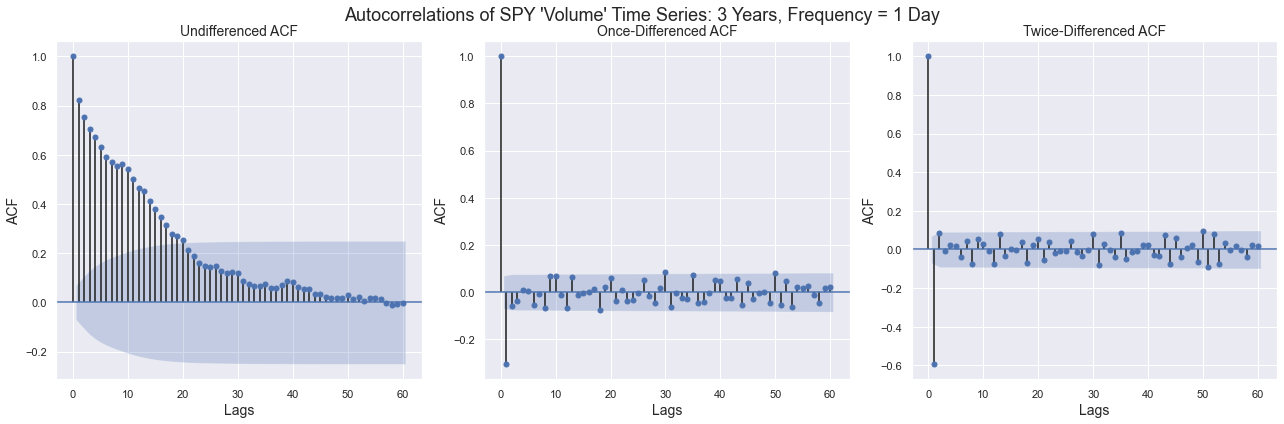

In [28]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

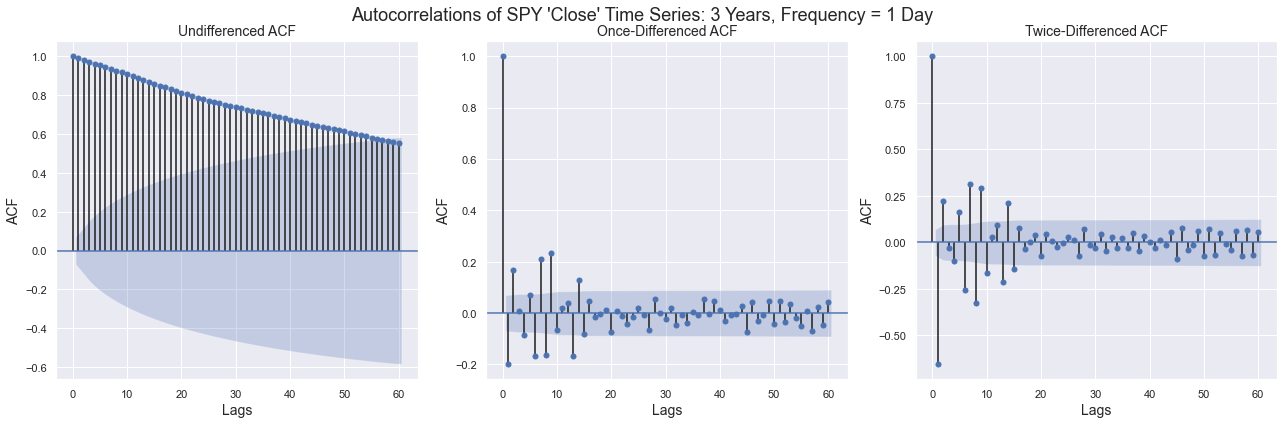

In [29]:
plot_acf_with_diff(df_full_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot Seasonal Decomposition

### 3 Years, Freq = Custom Business Day, Yearly Seasonality

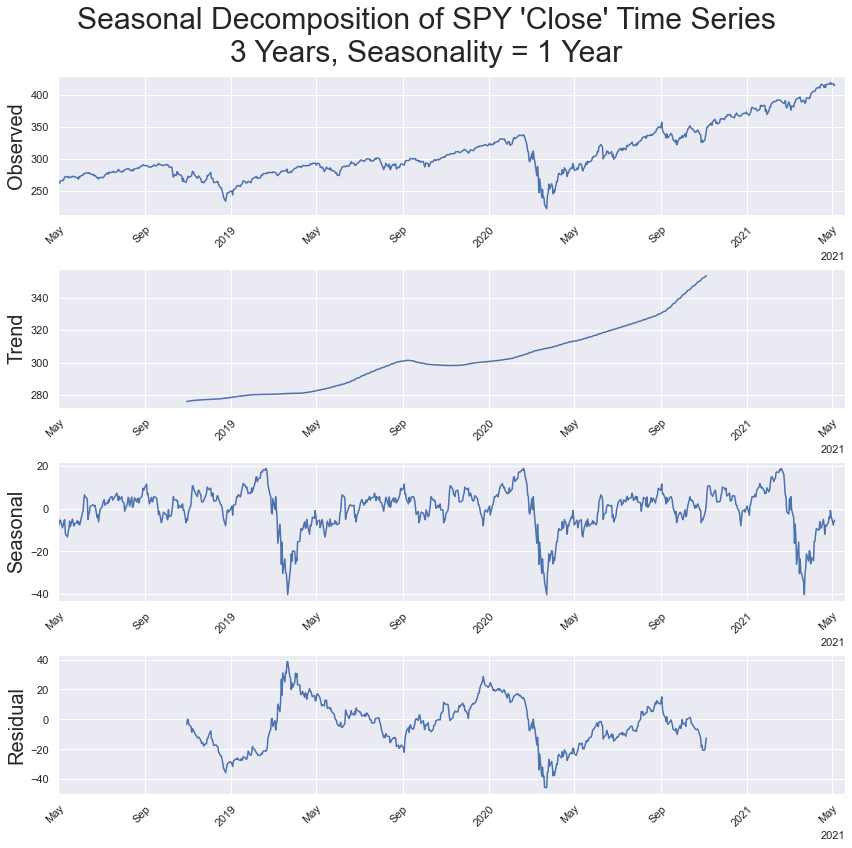

In [30]:
plot_seasonal_decomposition(df_full_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', 261)

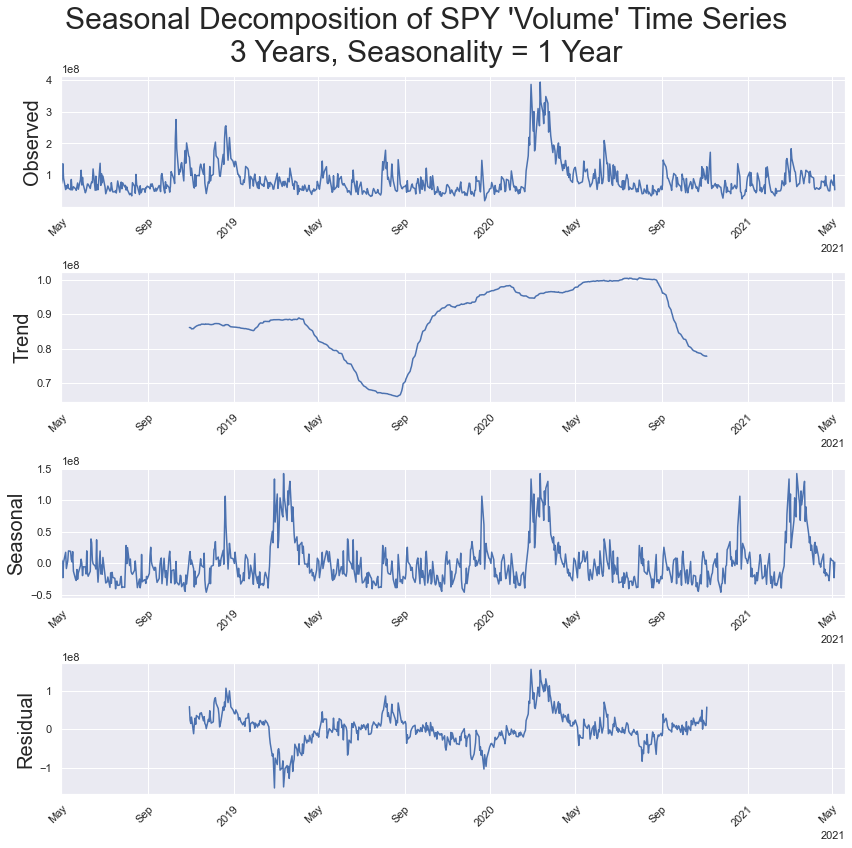

In [266]:
plot_seasonal_decomposition(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

### 5 Years, Freq = Custom Business Day, Yearly Seasonality

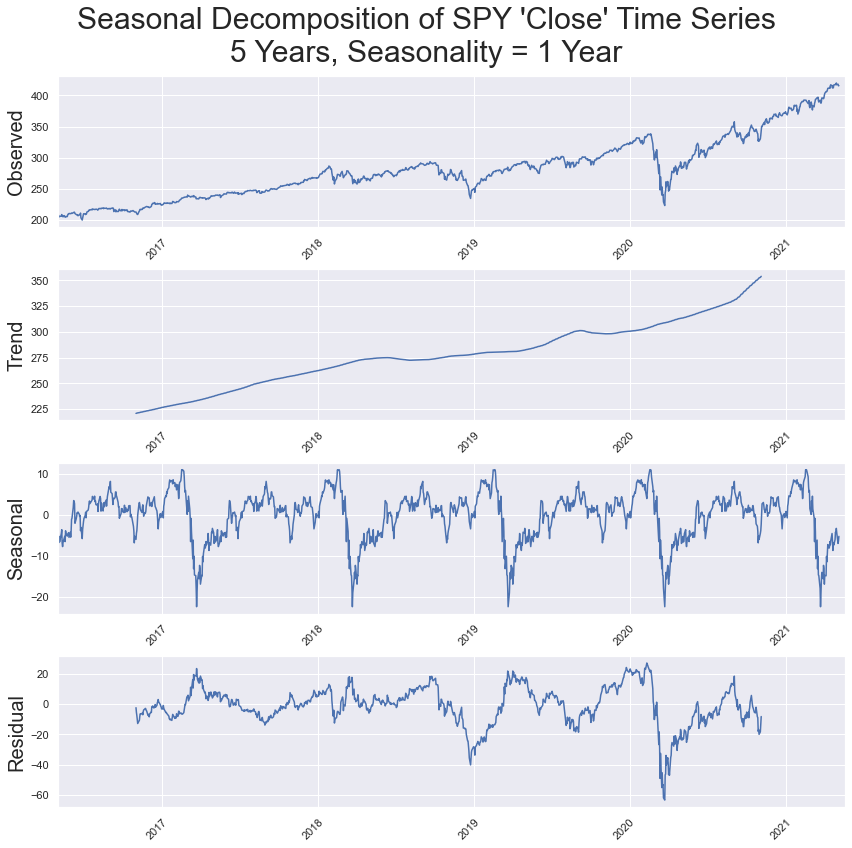

In [32]:
plot_seasonal_decomposition(df_full_5Y_close, 'SPY \'Close\'', 5, 'years', '1 Day', 261)

### 10 Years, Freq = Custom Business Day, Yearly Seasonality

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


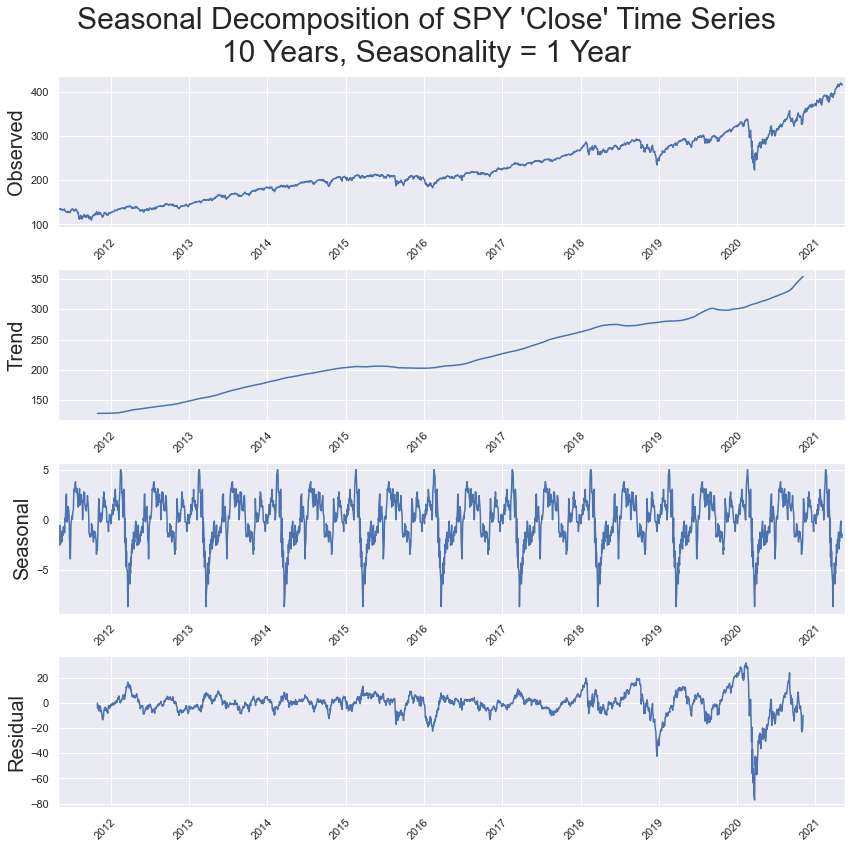

In [259]:
plot_seasonal_decomposition(df_full_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', 261)

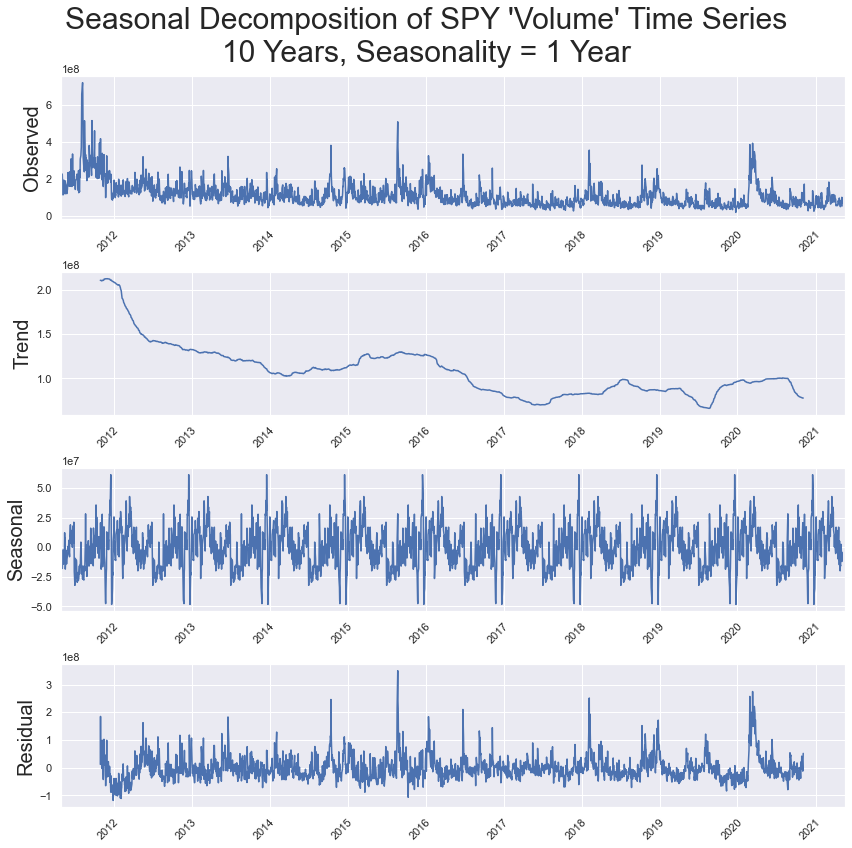

In [265]:
plot_seasonal_decomposition(df_full_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

# Modeling

## Last 3 Years, 1 Day

### Using Custom Class `Pmdarima_Model`

#### Close

In [34]:
pam_3Y = Pmdarima_Model(df_full_3Y_close, 'SPY \'Close\'',
               n=3, periods='years', freq='1 Day', seas=261, f_seas=261, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Pmdarima_Model.py loaded.
Starting AutoARIMA...
Data set diffs to use: 1
Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3527.576, Time=1.77 sec
First viable model found (3527.576)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3573.241, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3538.396, Time=1.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3546.957, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3571.436, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3527.400, Time=1.29 sec
New best model found (3527.400 < 3527.576)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3525.841, Time=1.30 sec
New best model found (3525.841 < 3527.400)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3527.046, Time=0.97 sec
 ARI

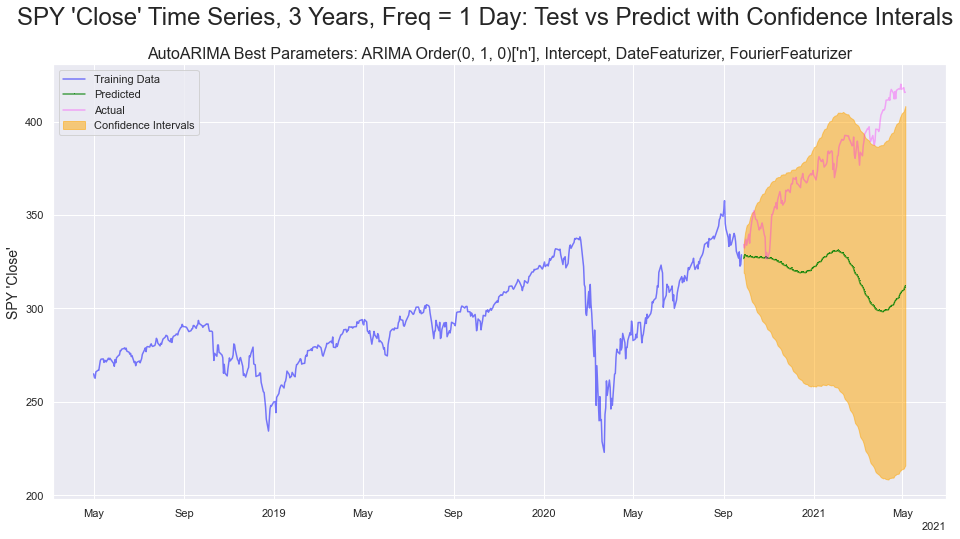

In [39]:
pam_3Y_auto_pipe = pam_3Y.run_auto_pipeline(verbose=1, visualize=True)

Starting step-wise cross-validation on best model from AutoArima...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
 Done.
Test AIC: 4366.90
Test RMSE: 3.57
This is 1.22% of the avg observed value.
Test SMAPE: 0.74%



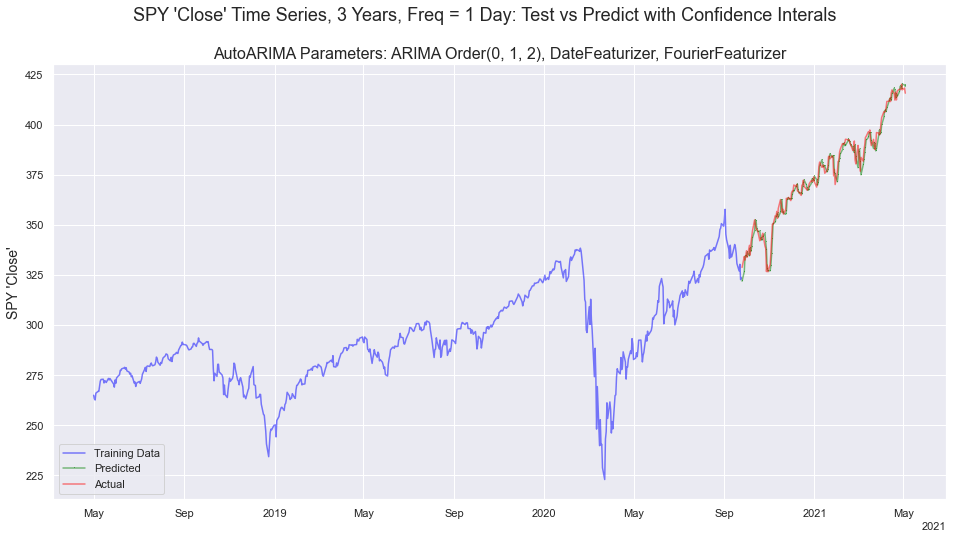

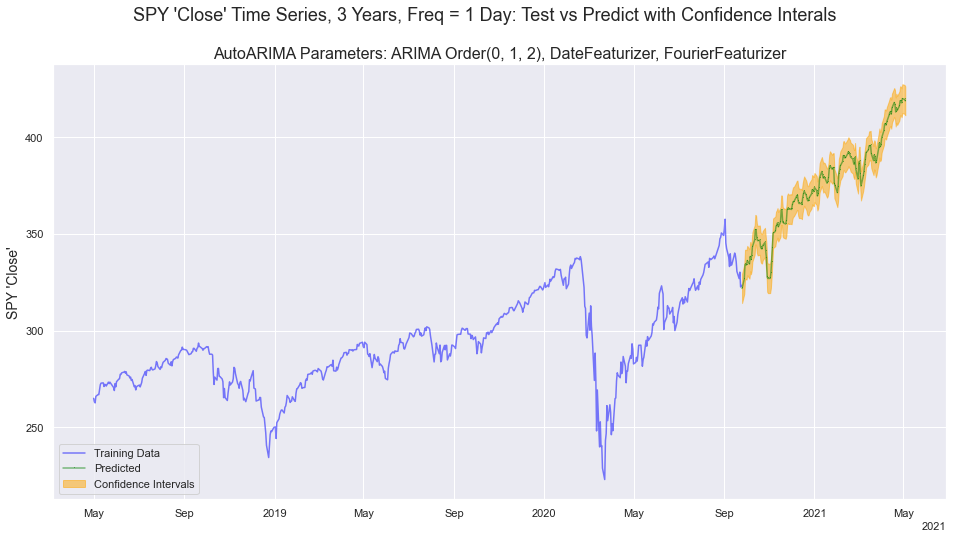

In [31]:
AIC, RMSE, SMAPE = pam_3Y.run_stepwise_cv(dynamic=False, verbose=1, visualize=True)

In [ ]:
pam_3Y_best = pam_3Y.run_gridsearch_CV(max_order=3, box=False, log=False, debug=True, parallel=False)

#### Volume

In [73]:
pam_3Y_vol = Pmdarima_Model(df_full_3Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=3, periods='years', freq='1 Day', trend='c', start_order=(1, 1, 1), seas=261, f_seas=261,
                            no_intercept=False, fit_seas=False,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Pmdarima_Model.py loaded.
Successfully created instance of Class Pmdarima_Model.


In [45]:
pam_3Y_vol_best, scores = pam_3Y_vol.run_gridsearch_CV(max_order=2,
                                                       t_list=['n','c','t','ct'],
                                                   fourier=True, box=False, log=True,
                                                   verbose=1, debug=True, parallel=False)

Pmdarima_Model.py loaded.
Starting GridSearchCV...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['ct'

ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 416.97 | RMSE: 27082379.31 | SMAPE 25.04
Model[ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=416.974 | RMSE=27082379.310 | SMAPE=25.035
First viable model found, RMSE=27082379.310
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 33581.30 | RMSE: 27360754.89 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=33581.299 | RMSE=27360754.889 | SMAPE=26.244
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 416.97 | RMSE: 27082379.31 | SMAPE 25.04
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=416.974 | RMSE=27082379.310 | SMAPE=25.035
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 33581.30 | RMSE: 27360754.89 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer]: AIC=33581.299 | RMSE=27360754.889 | SMAPE=26.244
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 418.97 | RMSE: 27106333.26 | SMAPE 25.05
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=418.973 | RMSE=27106333.261 | SMAPE=25.052
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27360800.37 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29282.260 | RMSE=27360800.372 | SMAPE=26.244
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 418.97 | RMSE: 27106333.26 | SMAPE 25.05
Model[ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=418.973 | RMSE=27106333.261 | SMAPE=25.052
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27360800.37 | SMAPE 26.24
Model[ARIMA Order(0, 1, 0)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29282.260 | RMSE=27360800.372 | SMAPE=26.244
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 422.99 | RMSE: 27168611.62 | SMAPE 25.22
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=422.985 | RMSE=27168611.620 | SMAPE=25.216
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27361186.13 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29282.261 | RMSE=27361186.127 | SMAPE=26.247
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 422.99 | RMSE: 27168611.62 | SMAPE 25.22
Model[ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=422.985 | RMSE=27168611.620 | SMAPE=25.216
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29282.26 | RMSE: 27361186.13 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29282.261 | RMSE=27361186.127 | SMAPE=26.247
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 423.20 | RMSE: 27115570.90 | SMAPE 25.16
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=423.198 | RMSE=27115570.898 | SMAPE=25.163
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29284.26 | RMSE: 27361682.26 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29284.264 | RMSE=27361682.262 | SMAPE=26.251
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 423.20 | RMSE: 27115570.90 | SMAPE 25.16
Model[ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=423.198 | RMSE=27115570.898 | SMAPE=25.163
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29284.26 | RMSE: 27361682.26 | SMAPE 26.25
Model[ARIMA Order(0, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29284.264 | RMSE=27361682.262 | SMAPE=26.251
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 290.34 | RMSE: 24157503.68 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=290.345 | RMSE=24157503.678 | SMAPE=23.733
Next best model found, RMSE=24157503.678
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29178.35 | RMSE: 24886741.51 | SMAPE 25.32
Model[ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29178.349 | RMSE=24886741.513 | SMAPE=25.319
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 290.34 | RMSE: 24157503.68 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=290.345 | RMSE=24157503.678 | SMAPE=23.733
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29178.35 | RMSE: 24886741.51 | SMAPE 25.32
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29178.349 | RMSE=24886741.513 | SMAPE=25.319
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 292.34 | RMSE: 24161128.83 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=292.344 | RMSE=24161128.833 | SMAPE=23.725
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.39 | RMSE: 24887979.13 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29180.385 | RMSE=24887979.130 | SMAPE=25.309
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 292.34 | RMSE: 24161128.83 | SMAPE 23.73
Model[ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=292.344 | RMSE=24161128.833 | SMAPE=23.725
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.39 | RMSE: 24887979.13 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29180.385 | RMSE=24887979.130 | SMAPE=25.309
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 299.67 | RMSE: 24194774.07 | SMAPE 23.49
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=299.670 | RMSE=24194774.067 | SMAPE=23.487
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.38 | RMSE: 24889667.99 | SMAPE 25.30
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29180.377 | RMSE=24889667.987 | SMAPE=25.304
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 299.67 | RMSE: 24194774.07 | SMAPE 23.49
Model[ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=299.670 | RMSE=24194774.067 | SMAPE=23.487
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29180.38 | RMSE: 24889667.99 | SMAPE 25.30
Model[ARIMA Order(0, 1, 1)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29180.377 | RMSE=24889667.987 | SMAPE=25.304
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 301.70 | RMSE: 24189725.87 | SMAPE 23.48
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=301.697 | RMSE=24189725.867 | SMAPE=23.478
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29182.39 | RMSE: 24888338.84 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29182.385 | RMSE=24888338.842 | SMAPE=25.307
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 301.70 | RMSE: 24189725.87 | SMAPE 23.48
Model[ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=301.697 | RMSE=24189725.867 | SMAPE=23.478
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29182.39 | RMSE: 24888338.84 | SMAPE 25.31
Model[ARIMA Order(0, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29182.385 | RMSE=24888338.842 | SMAPE=25.307
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 278.37 | RMSE: 24124558.39 | SMAPE 23.38
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=278.373 | RMSE=24124558.390 | SMAPE=23.382
Next best model found, RMSE=24124558.390
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29170.34 | RMSE: 24785841.20 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29170.339 | RMSE=24785841.197 | SMAPE=25.113
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 278.37 | RMSE: 24124558.39 | SMAPE 23.38
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=278.373 | RMSE=24124558.390 | SMAPE=23.382
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29170.34 | RMSE: 24785841.20 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29170.339 | RMSE=24785841.197 | SMAPE=25.113
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 280.38 | RMSE: 24124511.28 | SMAPE 23.37
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=280.382 | RMSE=24124511.275 | SMAPE=23.367
Next best model found, RMSE=24124511.275
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.34 | RMSE: 24785991.87 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29172.345 | RMSE=24785991.870 | SMAPE=25.109
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 280.38 | RMSE: 24124511.28 | SMAPE 23.37
Model[ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=280.382 | RMSE=24124511.275 | SMAPE=23.367
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.34 | RMSE: 24785991.87 | SMAPE 25.11
Model[ARIMA Order(0, 1, 2)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29172.345 | RMSE=24785991.870 | SMAPE=25.109
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 287.30 | RMSE: 24074918.45 | SMAPE 23.44
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=287.296 | RMSE=24074918.449 | SMAPE=23.439
Next best model found, RMSE=24074918.449
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.38 | RMSE: 24789176.85 | SMAPE 25.09
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29172.375 | RMSE=24789176.853 | SMAPE=25.094
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 287.30 | RMSE: 24074918.45 | SMAPE 23.44
Model[ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=287.296 | RMSE=24074918.449 | SMAPE=23.439
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29172.38 | RMSE: 24789176.85 | SMAPE 25.09
Model[ARIMA Order(0, 1, 2)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29172.375 | RMSE=24789176.853 | SMAPE=25.094
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 289.27 | RMSE: 24099625.32 | SMAPE 23.48
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=289.268 | RMSE=24099625.319 | SMAPE=23.483
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29174.41 | RMSE: 24795751.42 | SMAPE 25.08
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29174.414 | RMSE=24795751.421 | SMAPE=25.084
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 289.27 | RMSE: 24099625.32 | SMAPE 23.48
Model[ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=289.268 | RMSE=24099625.319 | SMAPE=23.483
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29174.41 | RMSE: 24795751.42 | SMAPE 25.08
Model[ARIMA Order(0, 1, 2)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29174.414 | RMSE=24795751.421 | SMAPE=25.084
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 329.83 | RMSE: 24841200.61 | SMAPE 23.39
Model[ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=329.832 | RMSE=24841200.615 | SMAPE=23.390
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29206.17 | RMSE: 25555022.13 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29206.169 | RMSE=25555022.133 | SMAPE=25.171
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 329.83 | RMSE: 24841200.61 | SMAPE 23.39
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=329.832 | RMSE=24841200.615 | SMAPE=23.390
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29206.17 | RMSE: 25555022.13 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29206.169 | RMSE=25555022.133 | SMAPE=25.171
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 331.83 | RMSE: 24854520.92 | SMAPE 23.40
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=331.828 | RMSE=24854520.920 | SMAPE=23.401
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.17 | RMSE: 25555250.37 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29208.174 | RMSE=25555250.372 | SMAPE=25.165
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 331.83 | RMSE: 24854520.92 | SMAPE 23.40
Model[ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=331.828 | RMSE=24854520.920 | SMAPE=23.401
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.17 | RMSE: 25555250.37 | SMAPE 25.17
Model[ARIMA Order(1, 1, 0)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29208.174 | RMSE=25555250.372 | SMAPE=25.165
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 333.66 | RMSE: 24778282.78 | SMAPE 23.41
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=333.660 | RMSE=24778282.784 | SMAPE=23.409
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.18 | RMSE: 25556054.69 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29208.176 | RMSE=25556054.690 | SMAPE=25.158
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 333.66 | RMSE: 24778282.78 | SMAPE 23.41
Model[ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=333.660 | RMSE=24778282.784 | SMAPE=23.409
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29208.18 | RMSE: 25556054.69 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29208.176 | RMSE=25556054.690 | SMAPE=25.158
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 335.93 | RMSE: 24793505.84 | SMAPE 23.45
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=335.934 | RMSE=24793505.841 | SMAPE=23.447
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29210.17 | RMSE: 25556431.84 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29210.175 | RMSE=25556431.840 | SMAPE=25.155
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 335.93 | RMSE: 24793505.84 | SMAPE 23.45
Model[ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=335.934 | RMSE=24793505.841 | SMAPE=23.447
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29210.17 | RMSE: 25556431.84 | SMAPE 25.16
Model[ARIMA Order(1, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29210.175 | RMSE=25556431.840 | SMAPE=25.155
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 267.73 | RMSE: 23994484.45 | SMAPE 22.88
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
Next best model found, RMSE=23994484.446
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29163.43 | RMSE: 24705623.64 | SMAPE 24.70
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29163.428 | RMSE=24705623.637 | SMAPE=24.700
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 267.73 | RMSE: 23994484.45 | SMAPE 22.88
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29163.43 | RMSE: 24705623.64 | SMAPE 24.70
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29163.428 | RMSE=24705623.637 | SMAPE=24.700
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 269.88 | RMSE: 23971769.85 | SMAPE 22.83
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
Next best model found, RMSE=23971769.850
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.59 | RMSE: 24708472.45 | SMAPE 24.66
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29165.592 | RMSE=24708472.449 | SMAPE=24.656
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 269.88 | RMSE: 23971769.85 | SMAPE 22.83
Model[ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.59 | RMSE: 24708472.45 | SMAPE 24.66
Model[ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29165.592 | RMSE=24708472.449 | SMAPE=24.656
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 284.68 | RMSE: 24063307.00 | SMAPE 23.32
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=284.682 | RMSE=24063307.000 | SMAPE=23.321
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.57 | RMSE: 24715963.90 | SMAPE 24.62
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29165.574 | RMSE=24715963.902 | SMAPE=24.623
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 284.68 | RMSE: 24063307.00 | SMAPE 23.32
Model[ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=284.682 | RMSE=24063307.000 | SMAPE=23.321
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29165.57 | RMSE: 24715963.90 | SMAPE 24.62
Model[ARIMA Order(1, 1, 1)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29165.574 | RMSE=24715963.902 | SMAPE=24.623
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 286.77 | RMSE: 24058126.59 | SMAPE 23.29
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=286.774 | RMSE=24058126.587 | SMAPE=23.295
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29167.59 | RMSE: 24709921.92 | SMAPE 24.65
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29167.594 | RMSE=24709921.925 | SMAPE=24.649
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 286.77 | RMSE: 24058126.59 | SMAPE 23.29
Model[ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=286.774 | RMSE=24058126.587 | SMAPE=23.295
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29167.59 | RMSE: 24709921.92 | SMAPE 24.65
Model[ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29167.594 | RMSE=24709921.925 | SMAPE=24.649
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 306.82 | RMSE: 24457608.35 | SMAPE 23.55
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=306.815 | RMSE=24457608.355 | SMAPE=23.550
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29188.55 | RMSE: 25186203.12 | SMAPE 25.28
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29188.548 | RMSE=25186203.118 | SMAPE=25.285
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 306.82 | RMSE: 24457608.35 | SMAPE 23.55
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=306.815 | RMSE=24457608.355 | SMAPE=23.550
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29188.55 | RMSE: 25186203.12 | SMAPE 25.28
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer]: AIC=29188.548 | RMSE=25186203.118 | SMAPE=25.285
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 308.81 | RMSE: 24470921.75 | SMAPE 23.57
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=308.815 | RMSE=24470921.751 | SMAPE=23.566
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.58 | RMSE: 25187021.10 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29190.576 | RMSE=25187021.095 | SMAPE=25.269
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 308.81 | RMSE: 24470921.75 | SMAPE 23.57
Model[ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=308.815 | RMSE=24470921.751 | SMAPE=23.566
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.58 | RMSE: 25187021.10 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['c'], DateFeaturizer, FourierFeaturizer]: AIC=29190.576 | RMSE=25187021.095 | SMAPE=25.269
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.42 | RMSE: 24430526.96 | SMAPE 23.66
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.423 | RMSE=24430526.957 | SMAPE=23.657
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.56 | RMSE: 25187267.49 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29190.556 | RMSE=25187267.490 | SMAPE=25.269
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.42 | RMSE: 24430526.96 | SMAPE 23.66
Model[ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.423 | RMSE=24430526.957 | SMAPE=23.657
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29190.56 | RMSE: 25187267.49 | SMAPE 25.27
Model[ARIMA Order(2, 1, 0)['t'], DateFeaturizer, FourierFeaturizer]: AIC=29190.556 | RMSE=25187267.490 | SMAPE=25.269
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.61 | RMSE: 24454074.11 | SMAPE 23.62
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.613 | RMSE=24454074.105 | SMAPE=23.623
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29192.59 | RMSE: 25185888.67 | SMAPE 25.29
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=29192.591 | RMSE=25185888.672 | SMAPE=25.289
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 311.61 | RMSE: 24454074.11 | SMAPE 23.62
Model[ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=311.613 | RMSE=24454074.105 | SMAPE=23.623
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer

Starting step-wise cross-validation...
ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 29192.59 | RMSE: 25185888.67 | SMAPE 25.29
Model[ARIMA Order(2, 1, 0)['ct'], DateFeaturizer, FourierFeaturizer]: AIC=29192.591 | RMSE=25185888.672 | SMAPE=25.289

GridsearchCV Completed.

Top 10 models:
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
Model[ARIMA Order(1, 1, 1)['c'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=269.885 | RMSE=23971769.850 | SMAPE=22.826
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=267.729 | RMSE=23994484.446 | SMAPE=22.879
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=286.774 | RMSE=24058126.587 | SMAPE=23.295
Model[ARIMA Order(1, 1, 1)['ct'], DateFeaturizer, FourierFeaturi

Pmdarima_Model.py loaded.
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 576.39
Test RMSE: 23724220.02
This is 26.96% of the avg observed value.
Test SMAPE: 22.21%



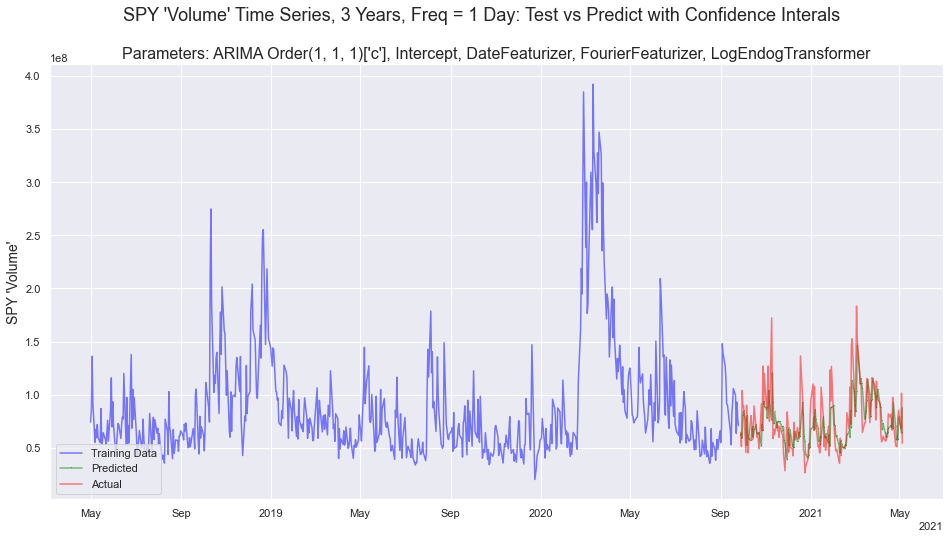

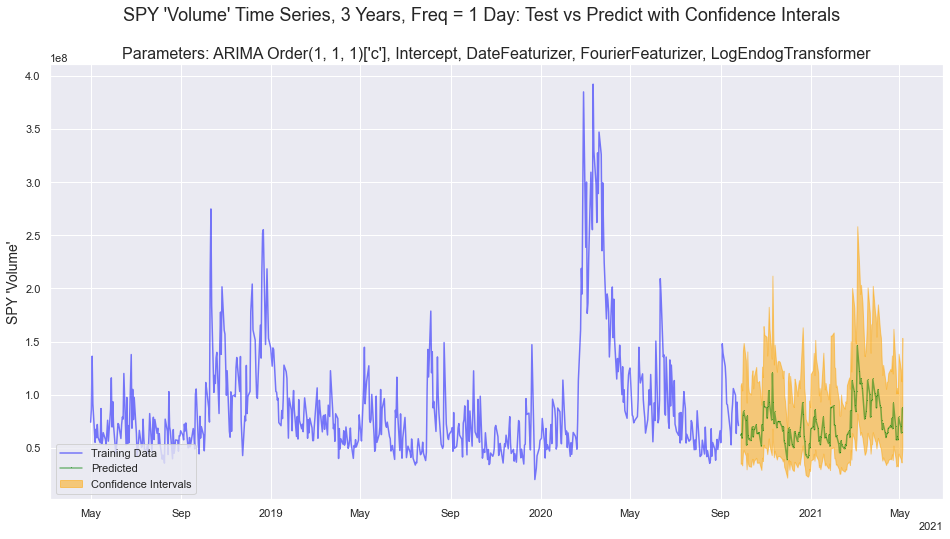

In [76]:
AIC, RMSE, SMAPE = pam_3Y_vol.run_stepwise_CV(pam_3Y_vol_best, dynamic=False, verbose=1, visualize=True)

### Cross-Validation

In [37]:
# cv = pam.model_selection.RollingForecastCV()
cv = pm.model_selection.SlidingWindowForecastCV(window_size=100,step=1)

#### Sliding Window

In [41]:
best_arima = pam_3Y_auto_pipe.named_steps['arima'].model_

In [42]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
cv = pm.model_selection.SlidingWindowForecastCV(window_size=200, step=1, h=100)
predictions = pm.model_selection.cross_val_predict(
    est, df_full_3Y_close, cv=cv, verbose=1, averaging="median")

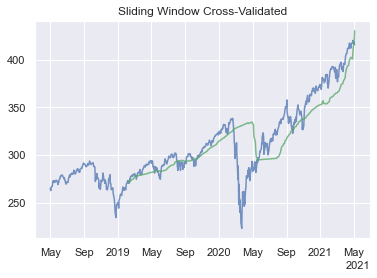

In [43]:
plt.plot(df_full_3Y_close.index, df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_full_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated")
plt.show()

#### Rolling

In [44]:
half_index = round(df_full_3Y_close.size/2)

In [45]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
# est = pipe
# cannot use pipeline
cv = pm.model_selection.RollingForecastCV(initial=half_index)
# cannot return conf_int, even with return_conf_int=True
predictions = pm.model_selection.cross_val_predict(
    est, df_full_3Y_close.interpolate(), cv=cv, verbose=1, averaging="median")


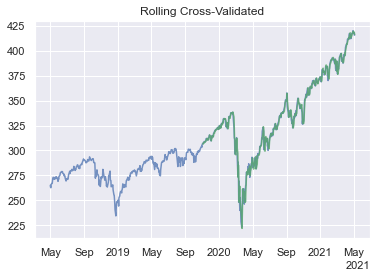

In [46]:
plt.plot(df_full_3Y_close.index, df_full_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_full_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Rolling Cross-Validated")
plt.show()

In [47]:
rmse = mse(df_full_3Y_close.interpolate()[-predictions.size:], predictions)
rmse

24.796568530528145

### Manual Run

In [50]:
train, test = pm.model_selection.train_test_split(df_full_3Y_close, train_size=80/100)

X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

In [53]:
train, test = pm.model_selection.train_test_split(df_full_3Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

In [55]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [56]:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 start_p=0,
                                 start_q=0,
                                 max_p=0,
                                 min_p=0,
                                 max_q=0,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [57]:
pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23420.807, Time=0.11 sec
First viable model found (23420.807)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26837.723, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.229 seconds


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, max_p=0, max_q=0, seasonal=False, start_p=0,
                           start_q=0, trace=3))])

In [61]:
y_hat = pipe.predict(X=X_test)

Text(0, 0.5, "(SPY 'Volume'")

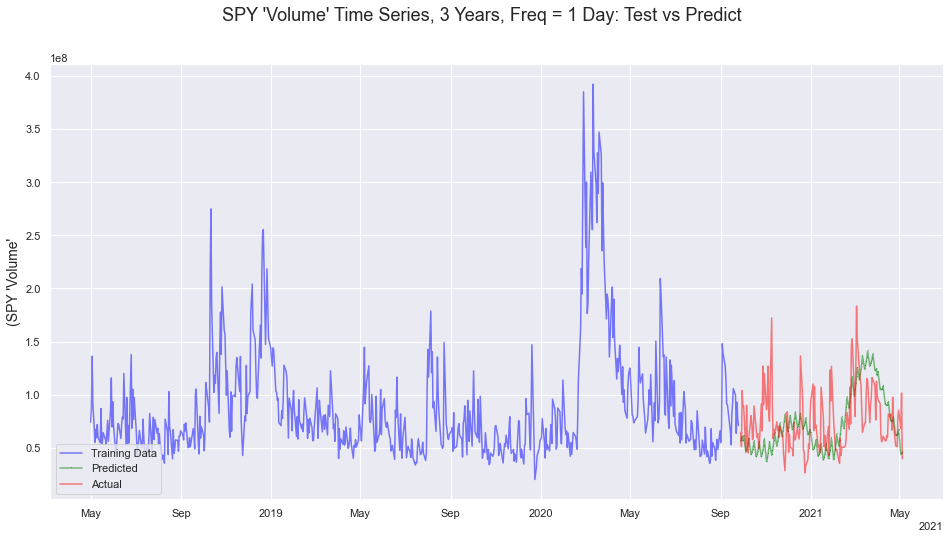

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
ax.plot(X_test, y_test, color='red', alpha=0.5, label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'SPY \'Volume\' Time Series, 3 Years, Freq = 1 Day: Test vs Predict\n', size=18)
# ax.set_title(f'Parameters: {params}', size=16)
ax.set_ylabel('(SPY \'Volume\'', size=14)

### Test out Stepwise CV

In [69]:
y_hat, conf_ints = pipe.predict(X=X_test, return_conf_int=True)

In [72]:
date = X_test.iloc[0].date + cbd
conf_int = np.asarray(conf_ints)

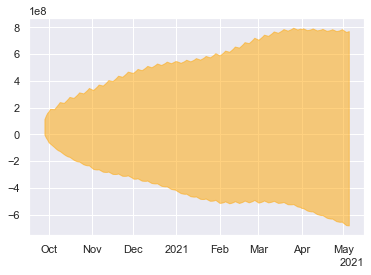

In [73]:
fig, ax = plt.subplots()
ax.fill_between(X_test.date,
               conf_int[:, 0], conf_int[:, 1],
               alpha=0.5, color='orange',
               label="Confidence Intervals")

Text(0, 0.5, "SPY 'Volume'")

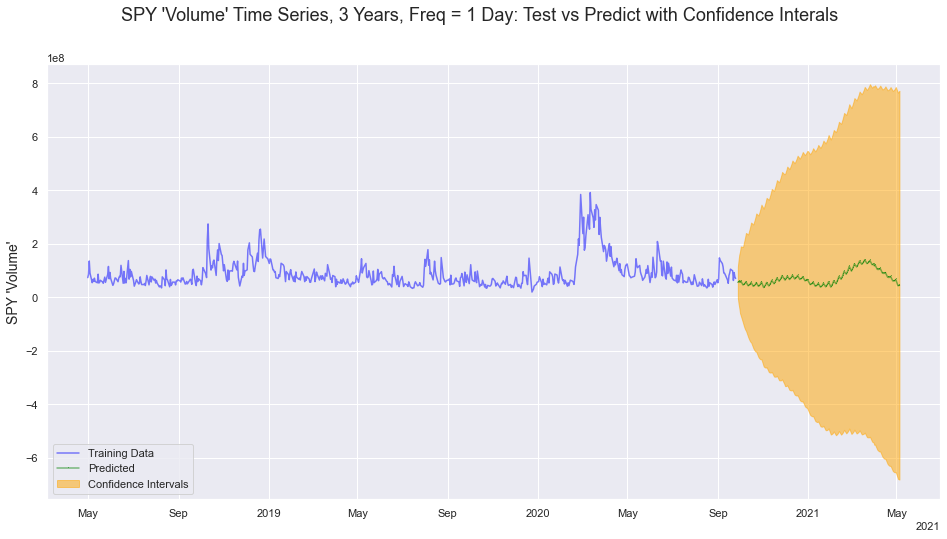

In [76]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
conf_int = np.asarray(conf_ints)
ax.fill_between(X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'SPY \'Volume\' Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=18)
ax.set_ylabel('SPY \'Volume\'', size=14)

## Last 5 Years, 1 Day

In [78]:
pam_5Y = Pmdarima_Model(df_full_5Y_close, 'SPY \'Close\'',
               n=3, periods='years', freq='1 Day', seas=261, f_seas=261, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


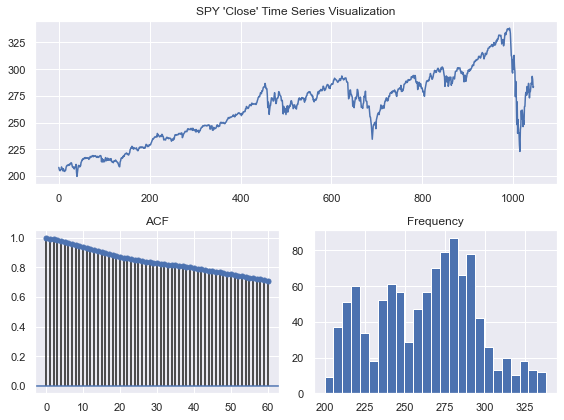

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5307.677, Time=3.28 sec
First viable model found (5307.677)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5379.218, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5327.182, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5338.783, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5377.775, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5309.119, Time=2.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5315.818, Time=4.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5242.366, Time=3.95 sec
New best model found (5242.366 < 5307.677)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5261.495, Time=2.98 sec
Near non-invertible roots for order (4, 1, 2)(0, 0, 0,

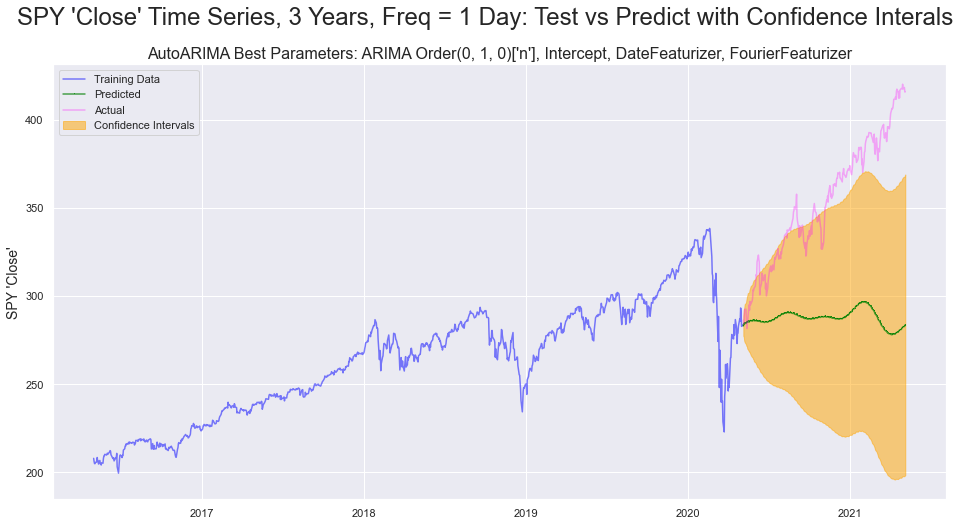

In [81]:
pam_5Y_close = pam_5Y.run_auto_pipeline(show_summary=True, visualize=True)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 6688.366
Test RMSE: 3.681
This is 1.399% of the avg observed value.
Test SMAPE: 0.819%



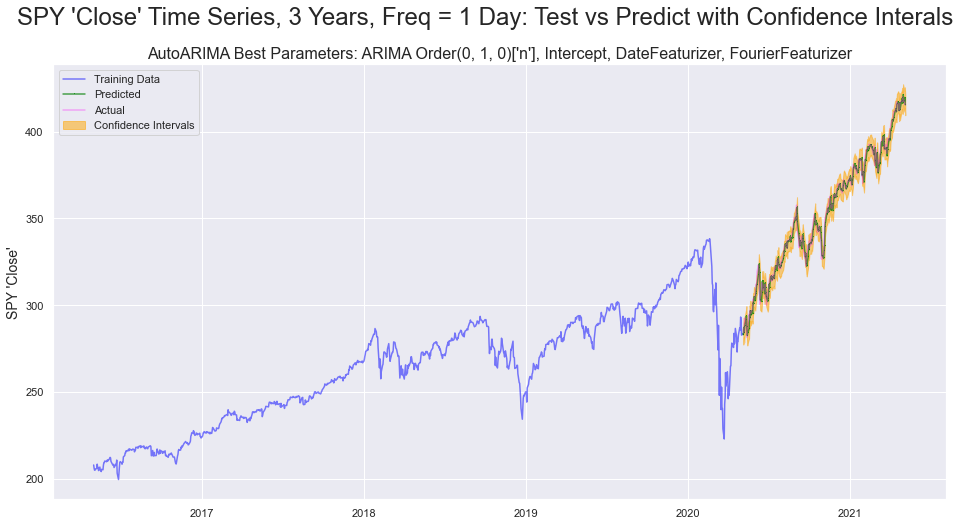

In [82]:
AIC, RMSE, SMAPE = pam_5Y.run_stepwise_CV(dynamic=False, visualize=True)

In [ ]:
pam_5Y_best = pam_5Y.run_gridsearch_CV(debug=True)

## Last 10 Years, 1 Day

In [83]:
pam_10Y_close = Pmdarima_Model(df_full_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Pmdarima_Model.py loaded.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8171.551, Time=12.96 sec
First viable model found (8171.551)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8174.157, Time=1.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8176.157, Time=0.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8176.157, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8176.288, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8170.200, Time=12.38 sec
New best model found (8170.200 < 8171.551)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8175.931, Time=1.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8177.685, Time=4.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8171.450, Time=12.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8177.888, Time=1.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8177.820, Time=1.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8174.204, Time=11.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8176.954, Time

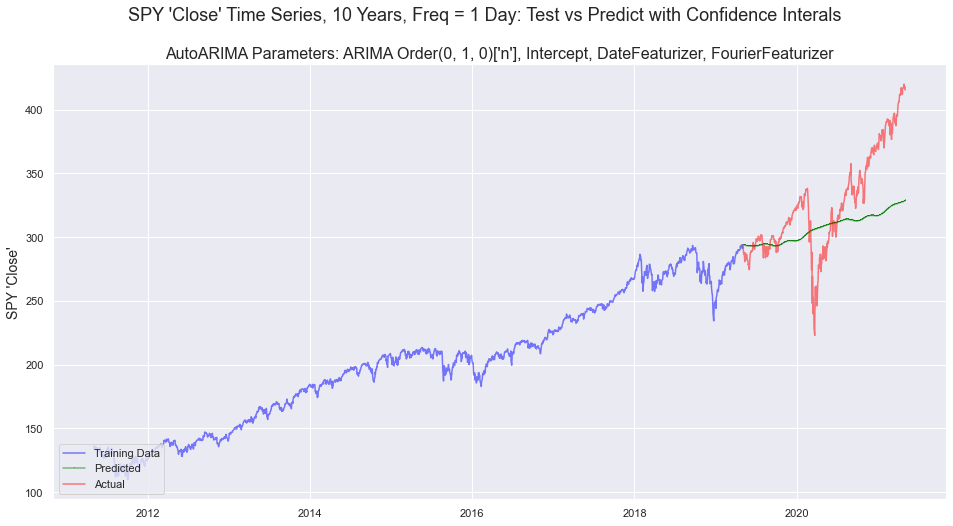

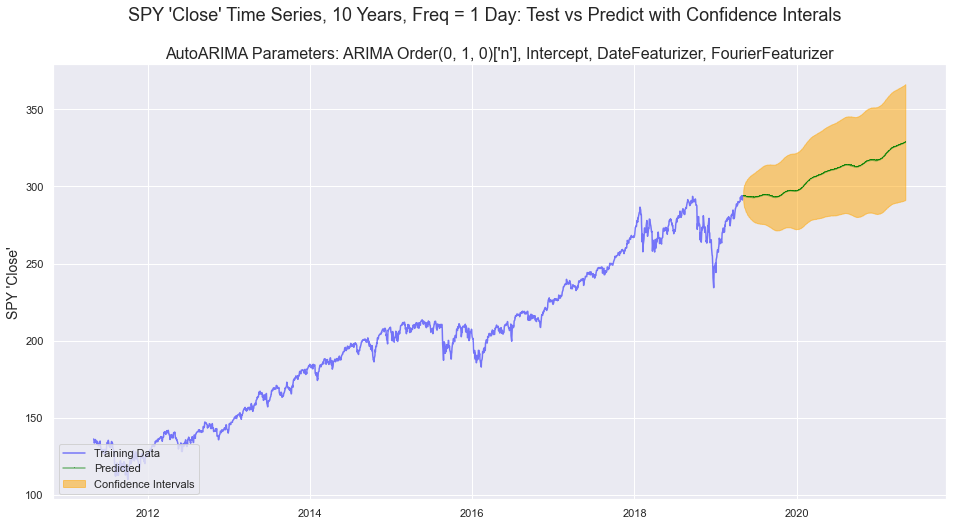

In [90]:
pam_10_pipe = pam_10Y_close.run_auto_pipeline(verbose=0, visualize=True)

### GridSearch

In [107]:
# Using an abbreviated set of params
pam_10Y_best, scores = pam_10Y_close.run_gridsearch_CV(max_order=2,
                                                 t_list=['t'],
                                                 fourier=True, box=False, log=False,
                                                 verbose=1, debug=True, parallel=False)

Pmdarima_Model.py loaded.
Starting GridSearchCV...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Finished building list of 6 models.
Running normally.


_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12312.32 | RMSE: 4.55 | SMAPE 0.94
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12312.321 | RMSE=4.546 | SMAPE=0.944
First viable model found, RMSE=4.546
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12294.24 | RMSE: 4.53 | SMAPE 0.94
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12294.240 | RMSE=4.531 | SMAPE=0.938
Next best model found, RMSE=4.531
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12230.52 | RMSE: 4.49 | SMAPE 0.93
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12230.519 | RMSE=4.490 | SMAPE=0.933
Next best model found, RMSE=4.490
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12254.54 | RMSE: 4.51 | SMAPE 0.94
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12254.538 | RMSE=4.512 | SMAPE=0.936
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12244.82 | RMSE: 4.47 | SMAPE 0.93
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12244.817 | RMSE=4.473 | SMAPE=0.931
Next best model found, RMSE=4.473
_____________________________________________________________________

Starting step-wise cross-validation...


> 
Done.
AIC: 12236.19 | RMSE: 4.51 | SMAPE 0.94
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12236.189 | RMSE=4.514 | SMAPE=0.937

GridsearchCV Completed.

Top 10 models:
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12244.817 | RMSE=4.473 | SMAPE=0.931
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12230.519 | RMSE=4.490 | SMAPE=0.933
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12254.538 | RMSE=4.512 | SMAPE=0.936
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12236.189 | RMSE=4.514 | SMAPE=0.937
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12294.240 | RMSE=4.531 | SMAPE=0.938
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12312.321 | RMSE=4.546 | SMAPE=0.944


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 17070.957
Test RMSE: 7.068
This is 3.521% of the avg observed value.
Test SMAPE: 1.011%



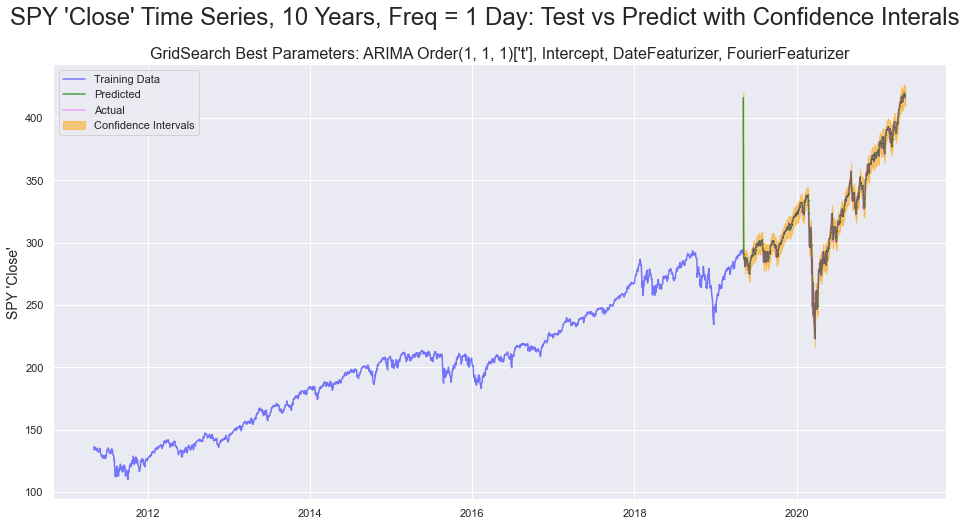

In [272]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_best, func='GS', dynamic=False, verbose=1, visualize=True)

Pmdarima_Model.py loaded.


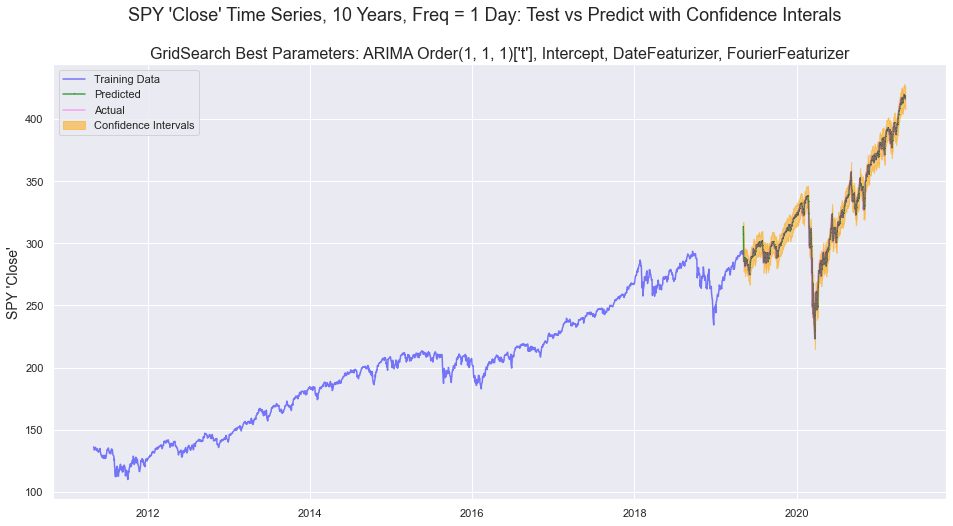

In [152]:
pam_10Y_close.plot_test_predict(pam_10Y_close.y_hat, func='GS', conf_ints=pam_10Y_close.conf_ints)

In [ ]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_close.GS_best_mod_pipe, dynamic=False, verbose=1, visualize=True)

#### Manual Run

In [ ]:
dates_10Y = pd.DataFrame(df_full_10Y_close.index, columns=['date'])
dates_10Y

In [57]:
date_df = new_dates_10Y_df[0:1]
date_df

,date
2613,2021-05-06 14:34:29.418608


##### Close Only

In [49]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [50]:
pam_10Y_close.fit(df_full_10Y_close, dates_10Y)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [58]:
# close_hat, close_conf_ints = pam_10Y_close.predict(X=new_dates_df, return_conf_int=True)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([416.04524828])

In [523]:
close_conf_ints

array([[409.31738871, 418.92767348]])

In [59]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
pam_10Y_close.fit(df_full_10Y_close, dates_10Y)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([415.9116414])

##### Volume

In [ ]:
pam_10Y_vol.fit(df_full_10Y_vol, dates_10Y)

In [ ]:
vol_hat, vol_conf_ints = pam_10Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

In [ ]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

In [96]:
train, test = pm.model_selection.train_test_split(df_full_10Y_close, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_10Y_close.length))
y_test = test.values

X_test

,date
2090,2019-05-06
2091,2019-05-07
2092,2019-05-08
2093,2019-05-09
2094,2019-05-10
...,...
2608,2021-04-29
2609,2021-04-30
2610,2021-05-03
2611,2021-05-04


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 730.867
Test RMSE: 31034500.027
This is 25.950% of the avg observed value.
Test SMAPE: 22.808%



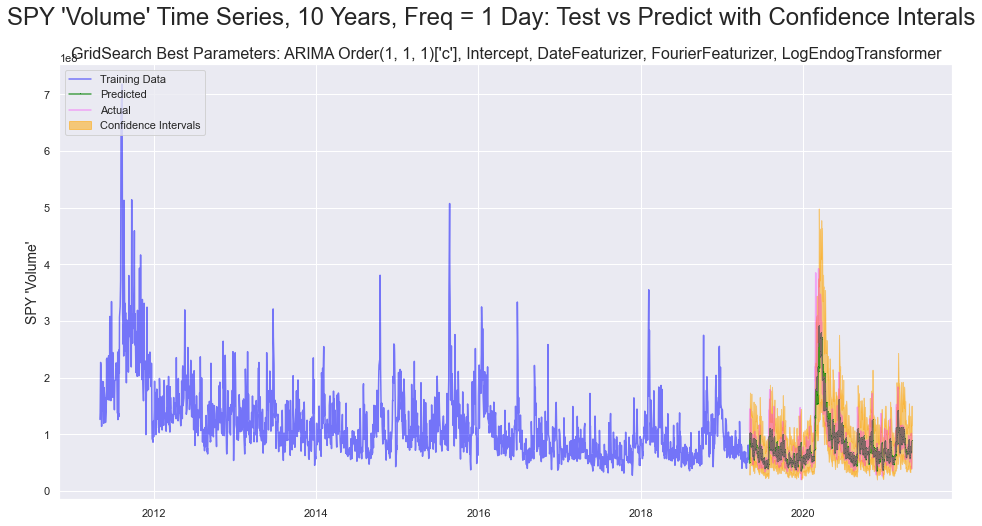

In [31]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(pam_10Y_vol_best, func='GS', dynamic=False, verbose=1, visualize=True)

In [33]:
pam_10Y_vol.y_hat

[49278028.8340929,
 82449731.30611807,
 101984583.51983163,
 80500324.25265357,
 92292008.34662569,
 78444889.21737492,
 100886386.30734552,
 80000935.58004633,
 76836001.5210743,
 82881419.30917634,
 76838319.05785337,
 70798961.88253729,
 60972670.820110105,
 60569060.58712146,
 92562203.48496078,
 54404790.1944264,
 67845140.0538666,
 73363562.7290432,
 90305556.69966596,
 72910096.03651996,
 72030314.06895778,
 88654665.88851836,
 81031001.12236844,
 76108807.98490693,
 79104752.01485673,
 65397294.18135849,
 68664931.36522743,
 68237528.9421217,
 58790742.089202955,
 62337002.7220155,
 50956061.28060004,
 50412105.49324121,
 77532351.71062009,
 73625690.61985487,
 97322340.84881155,
 66063103.48767689,
 57342196.63155666,
 77722317.71181978,
 59560014.24131452,
 54185186.77820849,
 54304261.638268776,
 72921728.02036957,
 65259186.134099156,
 51001442.313262865,
 56468662.6432633,
 47271553.34218468,
 51583688.404506505,
 48846367.50482711,
 57472925.041389994,
 56189179.28738522,

Pmdarima_Model.py loaded.


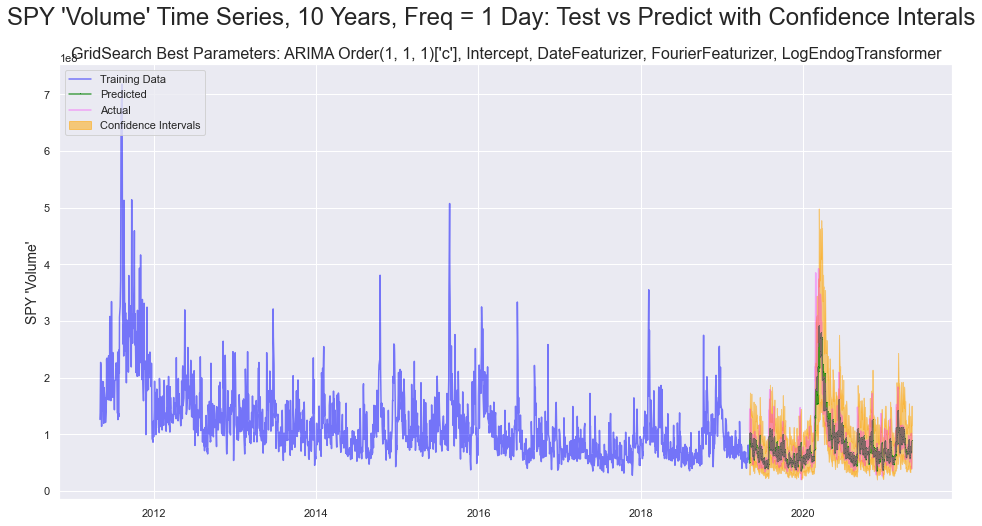

In [34]:
pam_10Y_vol.plot_test_predict(y_hat=pam_10Y_vol.y_hat, conf_ints=True, func='GS')
# AIC, RMSE, SMAPE = pam_10Y_vol.plot_test_predict(conf_ints=pam_10Y_vol.conf_ints, func='GS')

### Manual Forecast

In [ ]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
# _, X_train_feats = date_feat.fit_transform(y_train, X_train)
_, X_train_feats = date_feat.fit_transform(df_full_10Y_close, dates_10Y)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [ ]:
vol_10Y_df = pd.DataFrame(df_full_10Y_vol).reset_index()

In [ ]:
full_10Y_pipe.fit(df_full_10Y_close, vol_10Y_df)

In [ ]:
close_vol_hat, close_vol_conf_ints = full_10Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

In [203]:
close_vol_hat = np.asarray([414.79630855, 414.60707979, 414.48872733, 414.77080045,
       414.65227317])

In [ ]:
Audio(sound_file, autoplay=True)

#### Plot

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [ ]:
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
mpl.plot(spy_df_10Y[-120:],
         type='candle',
         style="yahoo",
         ax=ax,
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
# conf_int = np.asarray(close_vol_conf_ints)
conf_int = close_vol_conf_ints
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
equidate_ax(fig, ax, spy_df_10Y_fc[-125:].index.date)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 10 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

### Stepwise CV

In [437]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [454]:
# full_10Y_pipe.fit(df_full_10Y_close.values, pd.DataFrame(df_full_10Y_close.index))
# full_10Y_pipe.fit(df_full_10Y_close.values, dates_10Y)
full_10Y_pipe.fit(y_test, X_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3051.921, Time=1.07 sec
First viable model found (3051.921)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3090.663, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3059.319, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3067.151, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3090.010, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3050.890, Time=0.85 sec
New best model found (3050.890 < 3051.921)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3049.213, Time=0.79 sec
New best model found (3049.213 < 3050.890)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3050.648, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3057.010, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3050.165, Time=2.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3048.629, Time=0.78 sec
New best model found (3048.629 < 3049.213)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3067.371, Time=0.66 sec


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [467]:
# RMSE = mse(df_full_10Y_close, y_hat, squared=False)
RMSE = mse(test, y_hat, squared=False)
print("Test RMSE: %.2f" % RMSE)
print("This is %.2f%% of the avg observed value." % (100*RMSE/y_train.mean()))
print("Test SMAPE: %.2f%%\n" % smape(test, y_hat))
# print("Test SMAPE: %.2f%%\n" % smape(df_full_10Y_close, y_hat))

Test RMSE: 10.95
This is 5.46% of the avg observed value.
Test SMAPE: 1.07%



In [468]:
fc, conf_ints = model.predict(X=new_dates_df, return_conf_int=True)

In [469]:
fc

array([416.95933521, 413.52184596, 409.9202409 , 406.34035504,
       406.80537236])

In [470]:
conf_ints

array([[392.61884771, 441.2998227 ],
       [379.31263146, 447.73106046],
       [367.90927322, 451.93120859],
       [357.76492447, 454.9157856 ],
       [352.4526033 , 461.15814141]])

### Programmatically Forecasting

In [24]:
# defining it again in case it is lost from restarting notebook
train, test = pm.model_selection.train_test_split(df_full_10Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
X_test = pd.DataFrame(test.index, index=range(X_train.size, df_full_10Y_vol.size))
y_test = test.values
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
pam_10Y_vol_best = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('log', pm.preprocessing.LogEndogTransformer()),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Exogenous variable SPY 'Volume'...
Successfully fit model on historical observations.
Successfully forecasted 12 days forward.


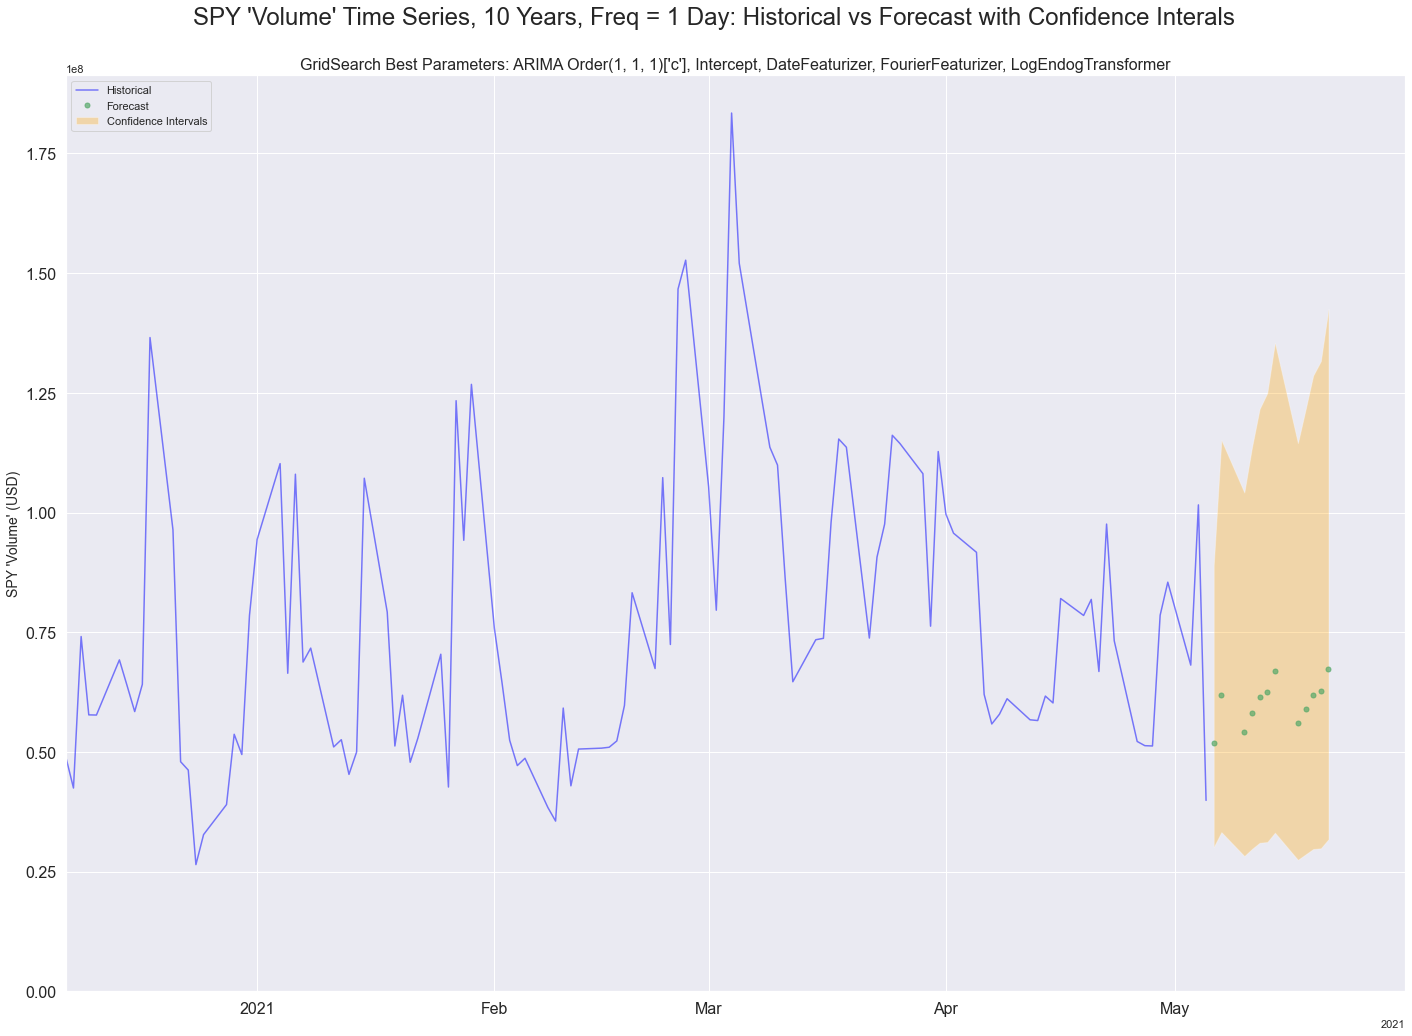

In [29]:
pam_10Y_vol = Pmdarima_Model(df_full_10Y_vol, 'SPY \'Volume\'', train_size=80, start_order=(1,1,1),
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261, trend='c',
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)
vol_10Y_hat_df, vol_10Y_hat, new_dates_df, vol_10Y_conf_ints = pam_10Y_vol.run_prediction(pam_10Y_vol_best, 12, fin=False,
                            en_ex='exog', hist_df=df_full_10Y_vol, func='GS', verbose=1)

In [247]:
exog_df = Pmdarima_Model.join_exog_data(new_dates_df, vol_10Y_hat_df)

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 12 days forward.


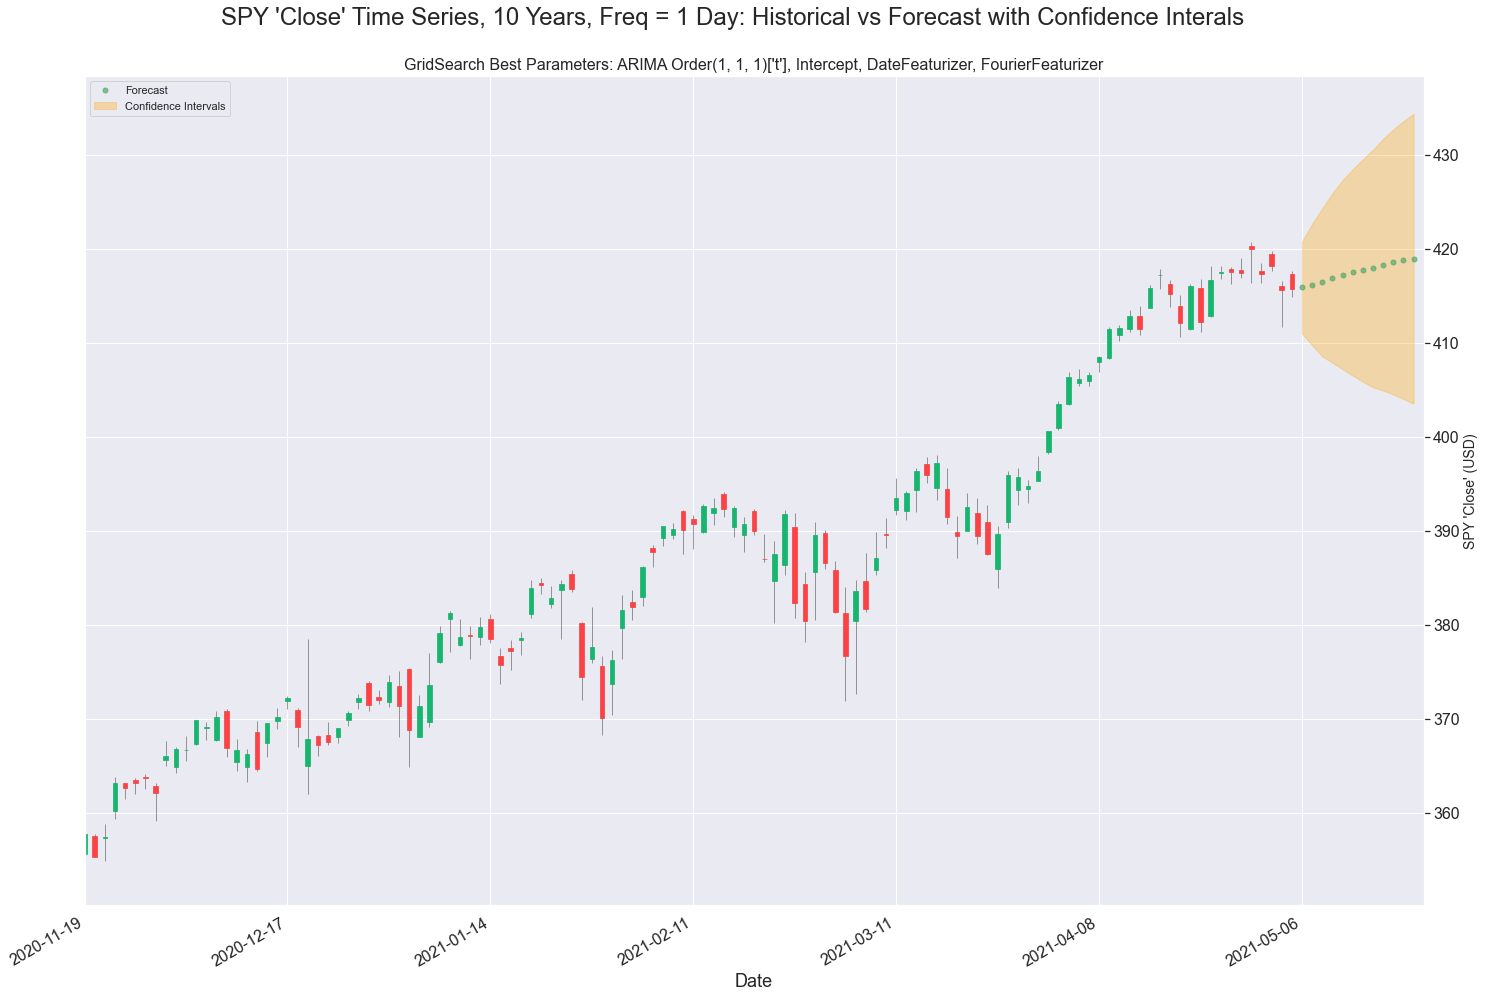

In [248]:
pam_10Y_close = Pmdarima_Model(df_full_10Y_close, 'SPY \'Close\'', train_size=80, start_order=(1,1,1),
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261, trend='t',
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_best, 12, fin=True,
                            exog_df=exog_df, en_ex='endo', ohlc_df=spy_df_10Y, func='GS', verbose=1)

## Manual testing of pmdarima

In [86]:
# df_train, df_test = train_test_split_data(df_full_10Y_close, 80, verbose=1)
df_train, df_test = train_test_split_data(df_full_3Y_close, 80, verbose=1)

##### Train-Test Split #####
Using a 80/20 train-test split...


In [108]:
new_mod = pm.auto_arima(df_train)

In [109]:
new_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1753.178
Date:                Thu, 06 May 2021   AIC                           3512.355
Time:                        13:47:23   BIC                           3525.688
Sample:                             0   HQIC                          3517.534
                                - 630                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1875      0.018    -10.434      0.000      -0.223      -0.152
ma.L2          0.2166      0.017     12.943      0.000       0.184       0.249
sigma2        15.4317      0.343     45.016      0.000      14.760      16.104
===================================================================================
Ljung-Box (Q):                      101.90   Jarque-Bera (JB):              3424.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.88   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
y_hat_test.size

158

In [134]:
start = df_train.size
end = df_full_3Y_close.size

In [140]:
y_hat_train, conf_int_train = new_mod.predict_in_sample(dynamic=False, return_conf_int=True)
y_hat_test, conf_int_test = new_mod.predict_in_sample(start=start, end=end-1, return_conf_int=True)
# y_hat_train, conf_int_train = new_mod.predict_in_sample(X=df_train.index, dynamic=False, return_conf_int=True)
# y_hat_test, conf_int_test = new_mod.predict_in_sample(X=df_test.index, return_conf_int=True)

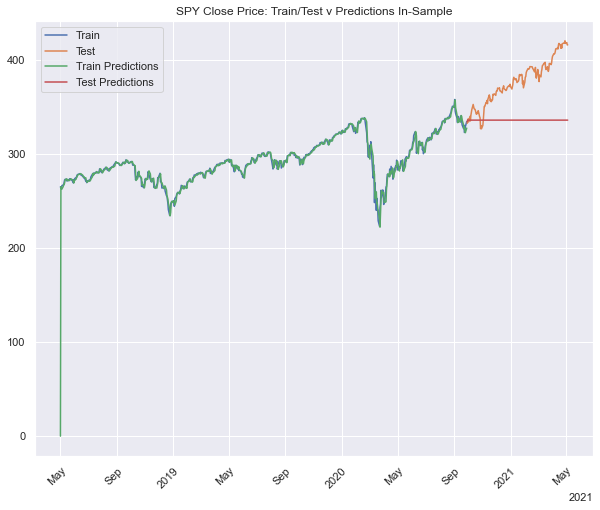

In [141]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(df_train.index, y_hat_train, label='Train Predictions')
ax.plot(df_test.index, y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()